# Signal Processing Project: real-time sound localisation

## 1 Offline system
### 1.1 Data generation and dataset

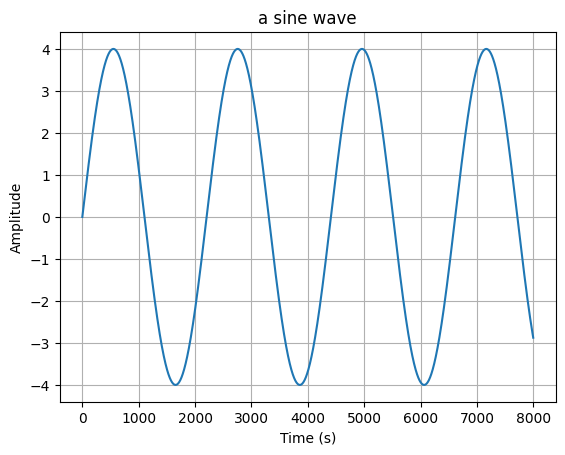

In [30]:
import numpy as np
import matplotlib.pyplot as plt


def create_sine_wave(f, A, fs, N):
    n = np.arange(0, N)
    out = A * np.sin(2 * np.pi * f * n / fs)
    return out


# call and test your function here #
fs = 44100
N = 8000
freq = 20
amplitude = 8 / 2  # 8 being the peak to peak amplitude
sine_wave = create_sine_wave(freq, amplitude, fs, N)
t = np.arange(0, N)

plt.title("a sine wave")
plt.plot(t, sine_wave)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.margins(x=0, y=0)s
plt.grid()
plt.show()

(44100, array([-20, -34, -34, ..., -39, -52, -33], dtype=int16))
(44100, array([-29, -10,  33, ..., -62, -19,   5], dtype=int16))
(44100, array([ -71,  -59,  -21, ..., -163, -169, -109], dtype=int16))
(44100, array([-55, -37,  -3, ...,  32,  43,  34], dtype=int16))
(44100, array([  52,   82,   79, ..., -128,  -89,  -45], dtype=int16))
(44100, array([-30, -13,  28, ..., 124,  76,  24], dtype=int16))
(44100, array([-111, -151, -164, ...,  -46,   -9,   10], dtype=int16))
(44100, array([-176, -194, -138, ...,   24,   20,   10], dtype=int16))
(44100, array([ 87, 175, 219, ...,  46,  36,  18], dtype=int16))
(44100, array([-105, -120,  -69, ...,   52,   61,   47], dtype=int16))
(44100, array([244, 265, 167, ...,  41,  38,  22], dtype=int16))
(44100, array([ -53,  -88, -110, ...,  -24,  -57,  -38], dtype=int16))
(44100, array([ 28,  17, -17, ..., 138,  77,  15], dtype=int16))
(44100, array([-131,  -93,   38, ...,  186,  161,   89], dtype=int16))
(44100, array([ 76,  47, -28, ..., -32,  25,  33

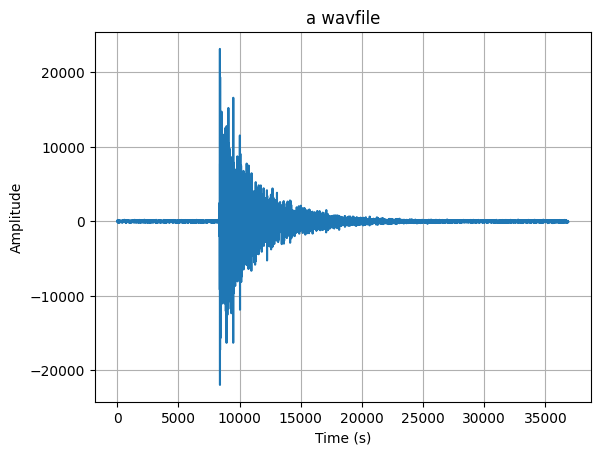

In [31]:
from glob import glob
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt


def read_wavefile(path):
    out = wf.read(path)
    return out


# call and test your function here #
LocateClaps = "./resources/LocateClaps"
files = glob(f"{LocateClaps}/*.wav")
for file in files:
    print(read_wavefile(file))

plt.title("a wavfile")
plt.plot(read_wavefile(files[0])[1])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.margins(x=0, y=0)
plt.grid()
plt.show()

### 1.2 Buffering

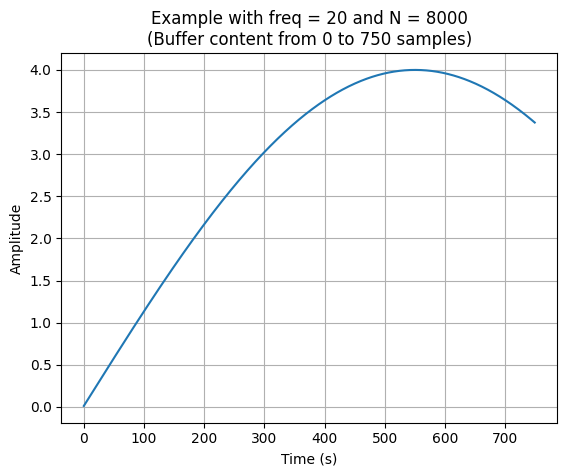

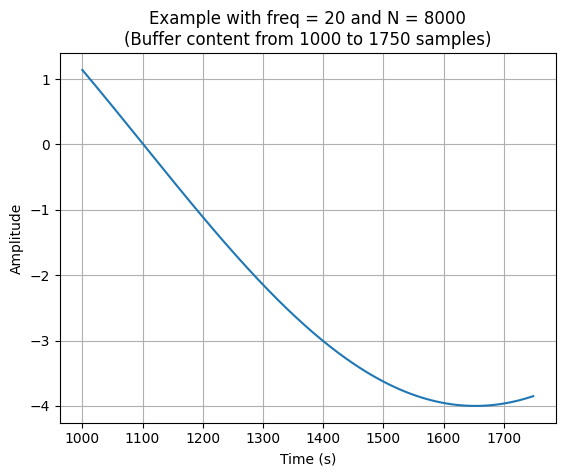

In [32]:
from collections import deque
import matplotlib.pyplot as plt


def create_ringbuffer(maxlen):
    out = deque(maxlen=maxlen)
    return out


# call and test your function here #
stride = 1000
maxlen = 750
ringbuffer = create_ringbuffer(maxlen)
sine_wave = create_sine_wave(20, 8 / 2, 44100, 8000)
# reading your signal as a stream:
for i, sample in enumerate(sine_wave):
    ringbuffer.append(sample)
    if i == ringbuffer.maxlen:
        t = np.arange(0, 750)

        plt.title("Example with freq = 20 and N = 8000\n(Buffer content from 0 to 750 samples)")
        plt.plot(t, ringbuffer)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        # plt.margins(x=0, y=0)
        plt.grid()
        plt.show()
    if i == ringbuffer.maxlen + stride:
        t = np.arange(1000, 1750)

        plt.title("Example with freq = 20 and N = 8000\n(Buffer content from 1000 to 1750 samples)")
        plt.plot(t, ringbuffer)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        # plt.margins(x=0, y=0)
        plt.grid()
        plt.show()

### 1.3 Pre-processing
#### 1.3.1 Normalisation

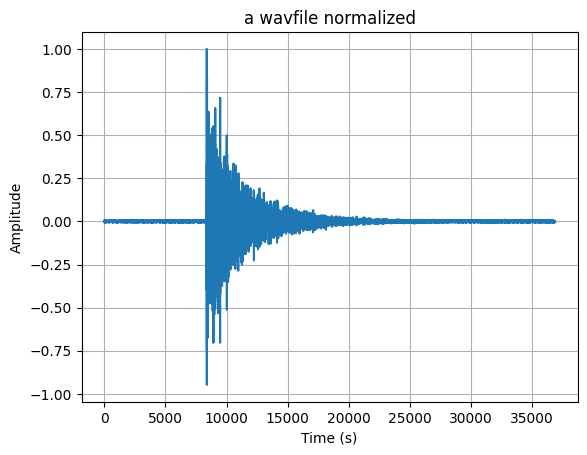

In [33]:
import matplotlib.pyplot as plt


def normalise(s):
    out = s/max(abs(s))
    return out


# call and test your function here #
signal = read_wavefile(files[0])[1]
normalised_signal = normalise(signal)

plt.title("a wavfile normalized")
plt.plot(normalised_signal)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.margins(x=0, y=0)
plt.grid()
plt.show()

#### 1.3.2 Downsampling

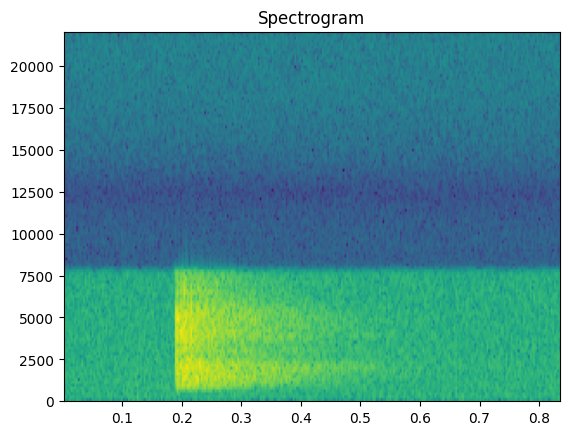

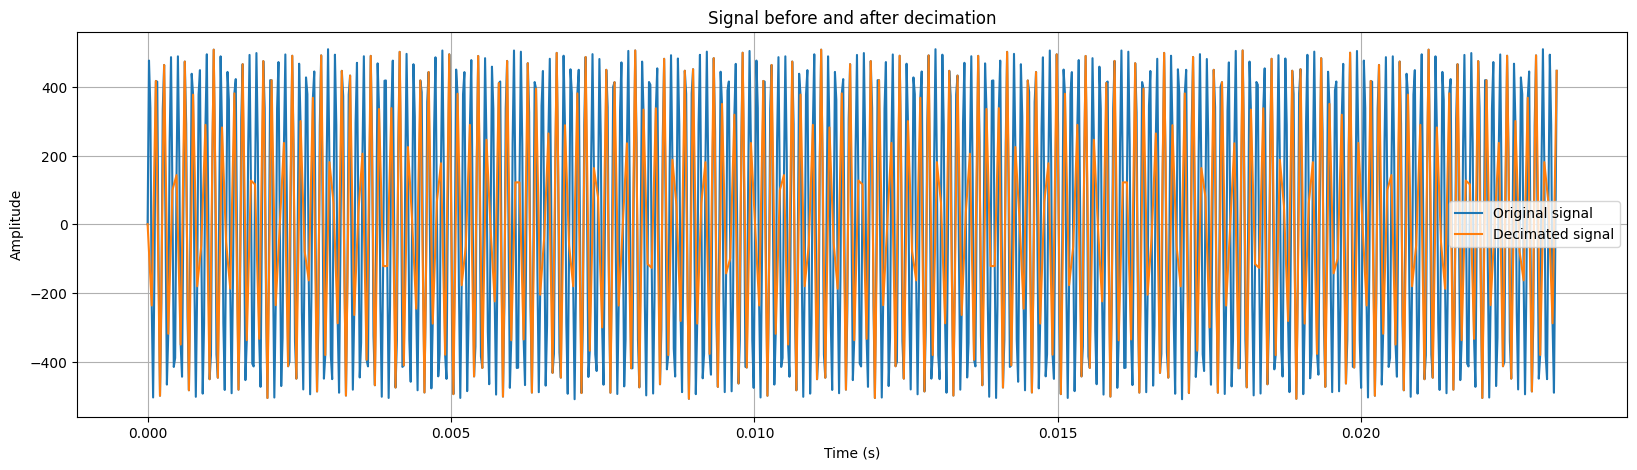

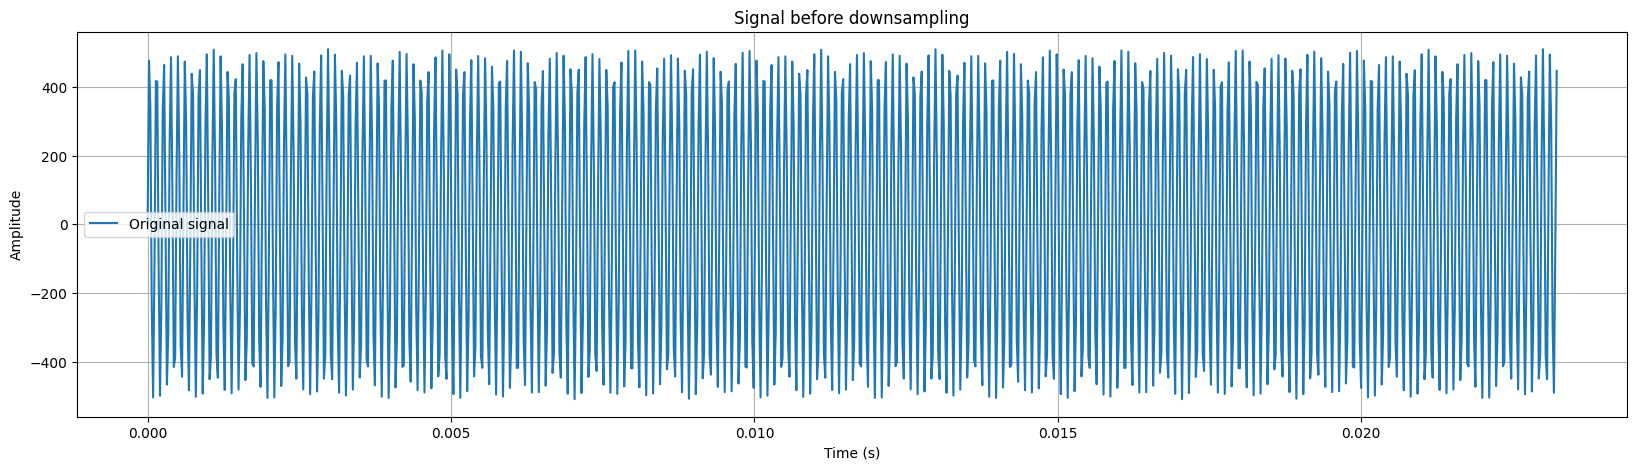

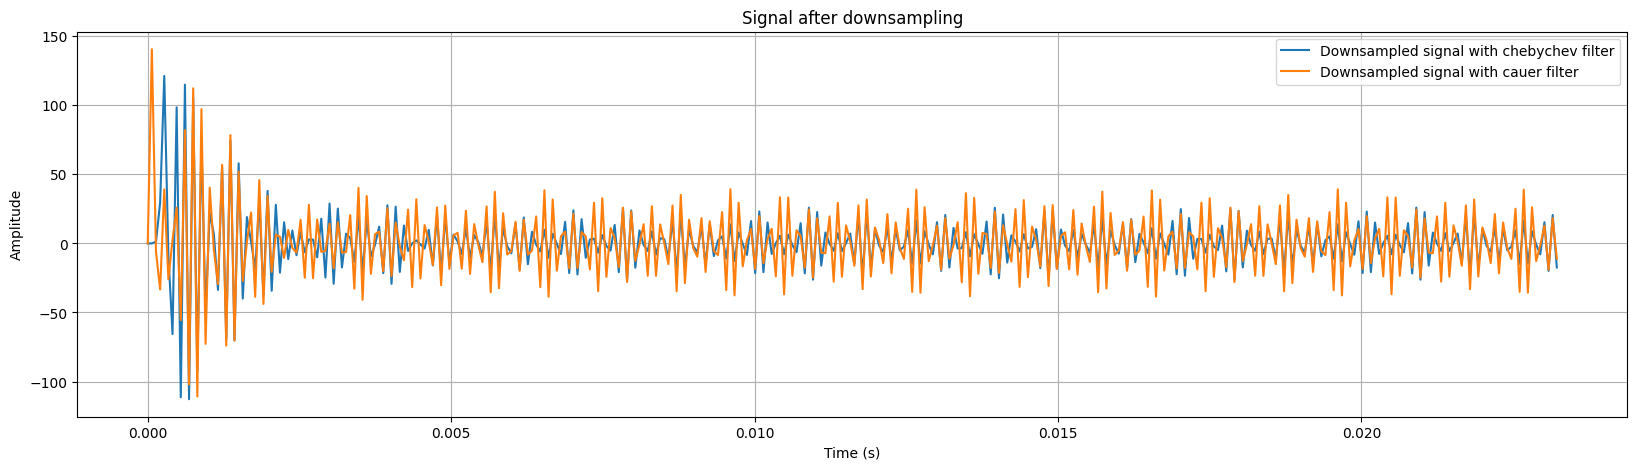

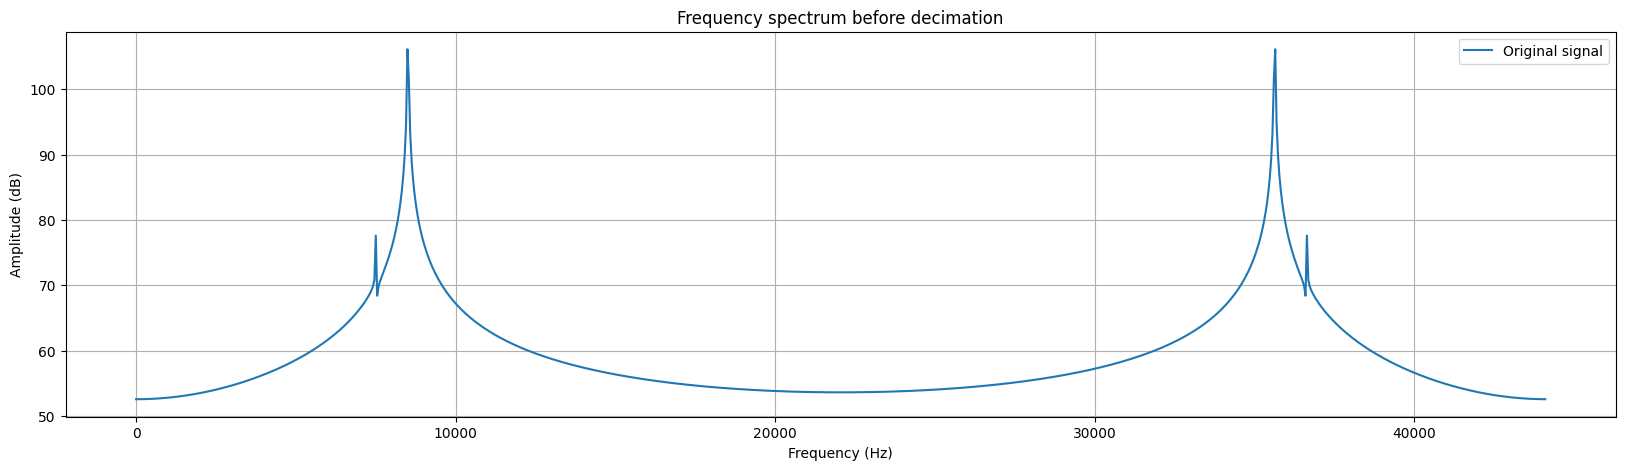

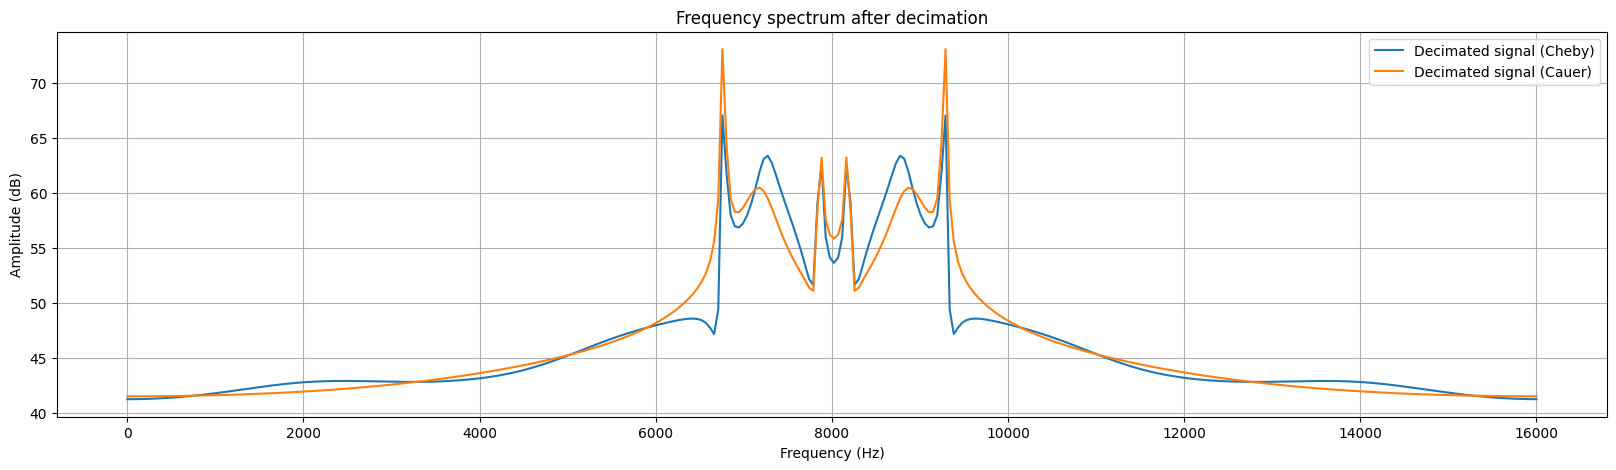

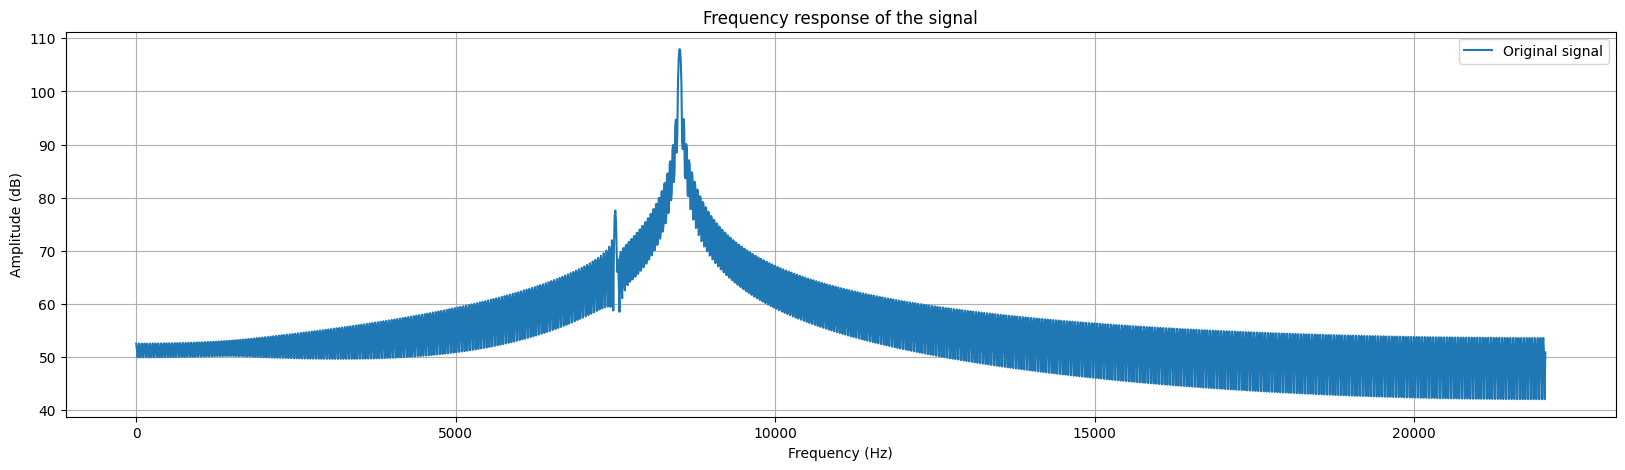

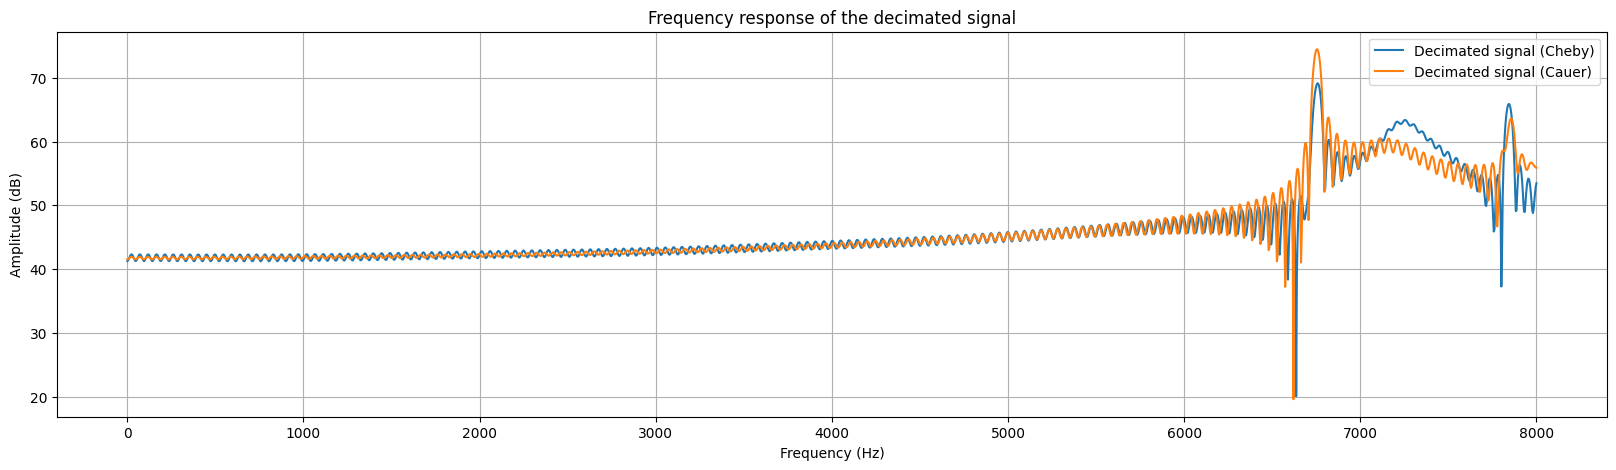

In [34]:
from scipy import signal as spsig

## 1 - spectral analysis via spectrogram
signal = read_wavefile(files[0])[1]

plt.specgram(signal, Fs=44100)
plt.title("Spectrogram")
plt.show()
"""1.3.2.1 [PAPER]
Les spectrogrammes observés ne dépassent pas
environ 8000Hz (Thm Shannon-Nyquist). On va donc rééchantillonner le signal à 16000 Hz."""


## 2 - Anti-aliasing filter synthesis
def create_filter_cheby(wp, ws, gpass, gstop, fs):
    # we need the chebychev order first
    cheby_order, wn = spsig.cheb1ord(wp, ws, gpass, gstop, fs)
    # then we can create the filter
    B, A = spsig.cheby1(cheby_order, gpass, wn, fs = fs)
    return B, A


def create_filter_cauer(wp, ws, gpass, gstop, fs):
    # we need the ellip order first
    ellip_order, wn = spsig.ellipord(wp, ws, gpass, gstop, fs)
    # then we can create the filter
    B, A = spsig.ellip(ellip_order, gpass, gstop, wn, fs = fs)
    return B, A


## 3 - Decimation
def downsampling(sig, B, A, M):
    # your code here #
    filtered_signal = spsig.lfilter(B, A, sig)
    # then we can decimate
    out = filtered_signal[::M]
    return out


# call and test your function here
fs = 44100
N = 1024
M = 3
signal1 = create_sine_wave(8500, 1000/2, fs, N)
signal2 = create_sine_wave(7500, 20/2, fs, N)
signal = signal1 + signal2
time_inter = N / fs
time_vector = np.linspace(0, time_inter, N)
decimated_signal = signal[::M]

plt.figure(figsize=(20, 5))
plt.plot(time_vector, signal)
plt.plot(time_vector[::M], decimated_signal)
plt.title("Signal before and after decimation")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(["Original signal", "Decimated signal"])
plt.grid()
plt.show()
# filters
wp = 16000 / 2
ws = wp + 1000
gpass = 0.1
gstop = 40
B, A = create_filter_cheby(wp, ws, gpass, gstop, fs)
B2, A2 = create_filter_cauer(wp, ws, gpass, gstop, fs)
# decimation
downsampled_signal = downsampling(signal, B, A, M)
downsampled_signal2 = downsampling(signal, B2, A2, M)

plt.figure(figsize=(20, 5))
plt.plot(time_vector, signal)
plt.title("Signal before downsampling")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(["Original signal"])
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(time_vector[::M], downsampled_signal)
plt.plot(time_vector[::M], downsampled_signal2)
plt.title("Signal after downsampling")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(["Downsampled signal with chebychev filter", "Downsampled signal with cauer filter"])
plt.grid()
plt.show()

#base signal
freq_base = np.fft.fft(signal)
freq_db = 20 * np.log10(np.abs(freq_base))
#freq_base = freq_base[:N//2]
#freq_db = freq_db[:N//2]

#decimated signal with chebychev filter
freq_base2 = np.fft.fft(downsampled_signal)
freq_db2 = 20 * np.log10(np.abs(freq_base2))
#freq_db2 = freq_db2[:N//2]

#decimated signal with cauer filter
freq_base3 = np.fft.fft(downsampled_signal2)
freq_db3 = 20 * np.log10(np.abs(freq_base3))
#freq_db3 = freq_db3[:N//2]

#frequency vector
freq_vector = np.linspace(0, fs, len(freq_db))
freq_vector2 = np.linspace(0, 16000, len(freq_db2))

plt.figure(figsize=(20, 5))
plt.plot(freq_vector, freq_db)
plt.title("Frequency spectrum before decimation")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.legend(["Original signal"])
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(freq_vector2, freq_db2)
plt.plot(freq_vector2, freq_db3)
plt.title("Frequency spectrum after decimation")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.legend(["Decimated signal (Cheby)", "Decimated signal (Cauer)"])
plt.grid()
plt.show()

w1, h1 = spsig.freqz(signal, a = 1, worN = 2048, whole = False, fs = fs)
freq_vector = np.linspace(0, fs//2, len(h1))

plt.figure(figsize=(20, 5))
plt.plot(freq_vector, 20 * np.log10(np.abs(h1)))
plt.title("Frequency response of the signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.legend(["Original signal"])
plt.grid()
plt.show()

w2, h2 = spsig.freqz(downsampled_signal, a = 1, worN = 2048, whole = False, fs = 16000)
w3, h3 = spsig.freqz(downsampled_signal2, a = 1, worN = 2048, whole = False, fs = 16000)
freq_vector2 = np.linspace(0, 16000//2, len(h2))

plt.figure(figsize=(20, 5))
plt.plot(freq_vector2, 20 * np.log10(np.abs(h2)))
plt.plot(freq_vector2, 20 * np.log10(np.abs(h3)))
plt.title("Frequency response of the decimated signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.legend(["Decimated signal (Cheby)", "Decimated signal (Cauer)"])
plt.grid()
plt.show()

### 1.4 Cross-correlation

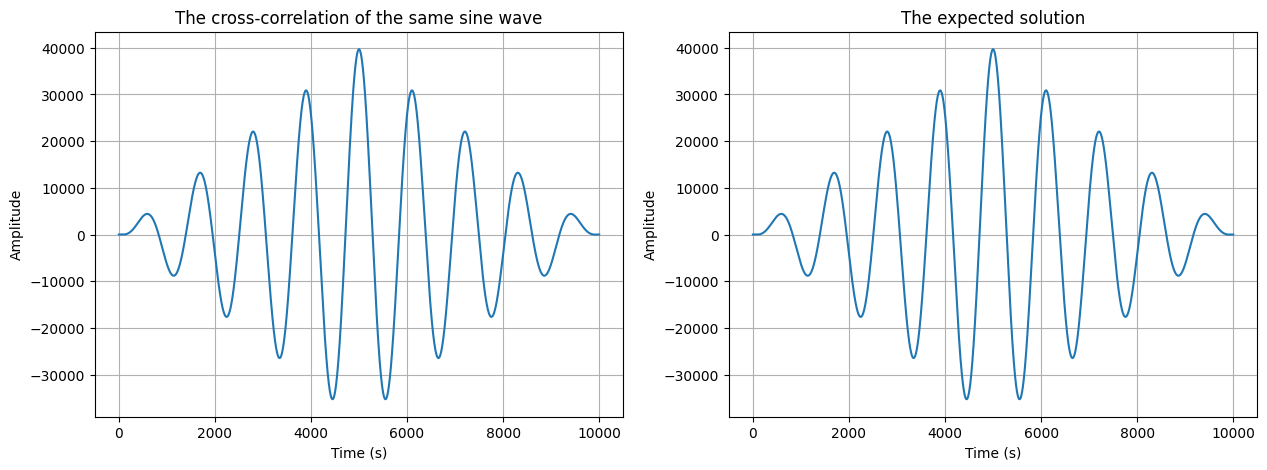

In [35]:
## 1.4
import scipy.signal as sc
import numpy as np


def fftxcorr(in1, in2):
    input1 = np.asarray(in1)
    input2 = np.asarray(in2)
    input1 = np.append(input1, np.zeros(len(in2)))
    input2 = np.append(np.zeros(len(in1)), input2)
    out = np.fft.ifft(np.fft.fft(input1) * np.conj(np.fft.fft(input2))).real
    return out  # sc.correlate(in1, in2, 'full')


# call and test your function here #
sine_wave = create_sine_wave(40, 4, 44100, 5000)
xcorr_fft = fftxcorr(sine_wave, sine_wave)
xcorr_fftconv = sc.fftconvolve(sine_wave, sine_wave[::-1], 'full') # [::-1] flips the signal but you can also use np.flip()

'''REMARQUE
len(xcorr_fft) = 10000 et len(xcorr_fftconv) = 9999,
en particulier xcorr_fft[1].
'''

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("The cross-correlation of the same sine wave")
plt.plot(xcorr_fft)
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.margins(x=0, y=0)
plt.subplot(1, 2, 2)
plt.title("The expected solution")
plt.plot(xcorr_fftconv)
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.margins(x=0, y=0)
plt.show()

### 1.5 Localisation
#### 1.5.1 TDOA

In [36]:
def TDOA(xcorr):
    out = np.where(xcorr == np.max(xcorr))[0][0] - len(xcorr) / 2
    return out

#### 1.5.2 Equation system

In [37]:
from scipy.optimize import root
import numpy as np

# mic coordinates in meters
MICS = [{'x': 0, 'y': 0.0487}, {'x': 0.0425, 'y': -0.025}, {'x': -0.0425, 'y': -0.025}]


def equations(p, deltas):
    v = 343
    x, y = p
    eq1 = v*deltas[0] - np.sqrt((MICS[0]['x'] - x)**2 + (MICS[0]['y'] - y)**2) + np.sqrt((MICS[1]['x'] - x)**2 + (MICS[1]['y'] - y)**2)
    eq2 = v*deltas[1] - np.sqrt((MICS[0]['x'] - x)**2 + (MICS[0]['y'] - y)**2) + np.sqrt((MICS[2]['x'] - x)**2 + (MICS[2]['y'] - y)**2)
    return (eq1, eq2)


def localize_sound(deltas):
    sol = root(equations, [0, 0], (deltas), tol=10)
    return sol.x


def source_angle(coordinates):
    import math
    unit_vector_src = coordinates / np.linalg.norm(coordinates)
    unit_vector_x_axis = [1, 0] / np.linalg.norm([1, 0])
    dot_product = np.dot(unit_vector_src, unit_vector_x_axis)
    out = math.degrees(np.arccos(dot_product))
    if coordinates[1] < 0:
        out = 360 - out
    return out


# call and test your function here #
mic1_coordinates = [0, 0.0487]
print(f'source_angle(mic1_coordinates) == 90.0 ? {source_angle(mic1_coordinates) == 90.0}')

source_angle(mic1_coordinates) == 90.0 ? True


### 1.6 System accuracy and speed

In [38]:
## 1.6.1

def accuracy(pred_angle, gt_angle, threshold):
    return min(abs(pred_angle - gt_angle), 360 - abs(pred_angle - gt_angle)) < threshold


## 1.6.2
possible_angle = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
LocateClaps = "./resources/LocateClaps"
files = glob(f"{LocateClaps}/*.wav")
B, A = create_filter_cauer(wp, ws, gpass, gstop, fs)  # operation lourde donc en dehors de la boucle
'''Choix de la valeur de threshold à justifier'''
threshold = 11
for angle in possible_angle:
    # 1.1 Data generation and dataset (read_wavefile(f)[1])
    m1_wavefile = []
    m2_wavefile = []
    m3_wavefile = []
    for f in files:
        if f'_{angle}.' in f:
            mic = f.split('/')[-1].split('_')[0] #if '/' does not work, use "\\" (windows notation)
            # 1.2 Buffering (Pas de son continue => Pas besoin de Ringbuffer)
            if mic == 'M1':
                m1_wavefile = read_wavefile(f)[1]
            elif mic == 'M2':
                m2_wavefile = read_wavefile(f)[1]
            elif mic == 'M3':
                m3_wavefile = read_wavefile(f)[1]
    # 1.3 Pre-processing
    ## 1.3.1 Normalisation
    m1_wavefile = normalise(m1_wavefile)
    m2_wavefile = normalise(m2_wavefile)
    m3_wavefile = normalise(m3_wavefile)
    ## 1.3.2 Downsampling
    wp = 16000 / 2
    ws = wp + 1000
    gpass = 0.1
    gstop = 40
    M = 3
    m1_wavefile = downsampling(m1_wavefile, B, A, M)
    m2_wavefile = downsampling(m2_wavefile, B, A, M)
    m3_wavefile = downsampling(m3_wavefile, B, A, M)
    # 1.4 Cross-correlation
    m12_xcorr_fft = fftxcorr(m1_wavefile, m2_wavefile)
    m13_xcorr_fft = fftxcorr(m1_wavefile, m3_wavefile)
    # 1.5 Localisation
    ## 1.5.1 TDOA
    m12_time_shift_value = TDOA(m12_xcorr_fft) / 16000
    m13_time_shift_value = TDOA(m13_xcorr_fft) / 16000
    """print(f'''for {str(angle)}
    m12_time_shift_value = {m12_time_shift_value}
    m13_time_shift_value = {m13_time_shift_value}
    ''')"""
    ## 1.5.2 Equation system
    coordinates_sound = localize_sound([m12_time_shift_value, m13_time_shift_value])

    pred_angle = source_angle(coordinates_sound)
    print(f'angle prédit, angle attendu, précision : {pred_angle}, {angle}, {accuracy(pred_angle, angle, threshold)}')

## 1.6.3
from time import time_ns, sleep

def func_example(a, b):
    return a*b

def time_delay(func, args):
    start_time = time_ns()
    out = func(*args)
    end_time = time_ns()
    print(f"{func.__name__} in {end_time - start_time} ns")
    return out

product = time_delay(func_example, [2, 10])

# call and test your previous functions here #
signal_test = read_wavefile(files[0])[1]
signal_test_norm = time_delay(normalise, [signal_test])
signal_test_down = time_delay(downsampling, [signal_test_norm, B, A, M])
signal_xcorr_fft = time_delay(fftxcorr, [signal_test_down, signal_test_down])
signal_test_tdoa = time_delay(TDOA, [signal_xcorr_fft]) / 16000
signal_test_loc = time_delay(localize_sound, [[signal_test_tdoa, signal_test_tdoa]])
signal_test_source = time_delay(source_angle, [signal_test_loc])

angle prédit, angle attendu, précision : 359.5355334769469, 0, True
angle prédit, angle attendu, précision : 29.2984006008584, 30, True
angle prédit, angle attendu, précision : 70.52162196726081, 60, True
angle prédit, angle attendu, précision : 90.0, 90, True
angle prédit, angle attendu, précision : 109.47837900124702, 120, True
angle prédit, angle attendu, précision : 150.7016059969867, 150, True
angle prédit, angle attendu, précision : 180.46447521544258, 180, True
angle prédit, angle attendu, précision : 210.23170989672286, 210, True
angle prédit, angle attendu, précision : 250.9265238427176, 240, True
angle prédit, angle attendu, précision : 270.0, 270, True
angle prédit, angle attendu, précision : 289.07347709131614, 300, True
angle prédit, angle attendu, précision : 329.7682965793285, 330, True
func_example in 1000 ns
normalise in 2522000 ns
downsampling in 356000 ns
fftxcorr in 8633000 ns
TDOA in 105000 ns
localize_sound in 144000 ns
source_angle in 46000 ns


## 2 Real-time localisation

### 2.1 Research one Raspberry Pi application

### 2.2 Data acquisition and processing

In [39]:
#### Callback 
import pyaudio

RESPEAKER_CHANNELS = 8
BUFFERS = []

def callback(in_data, frame_count, time_info, flag):
    global BUFFERS
    data = np.frombuffer(in_data, dtype=np.int16)
    BUFFERS[0].extend(data[0::RESPEAKER_CHANNELS])
    BUFFERS[1].extend(data[2::RESPEAKER_CHANNELS])
    BUFFERS[2].extend(data[4::RESPEAKER_CHANNELS])
    return (None, pyaudio.paContinue)

#### Stream management

RATE = 44100
RESPEAKER_WIDTH = 2
CHUNK_SIZE = 2048

def init_stream():
    print("========= Stream opened =========")
    p = pyaudio.PyAudio()
    for i in range(p.get_device_count()):
        device_info = p.get_device_info_by_index(i)

        if device_info['maxInputChannels'] == 8:
            INDEX = i
            break

        if i == p.get_device_count()-1:
            # Sound card not found
            raise OSError('Invalid number of channels')

    stream = p.open(rate=RATE, channels=RESPEAKER_CHANNELS, format=p.get_format_from_width(RESPEAKER_WIDTH), input=True, input_device_index=INDEX,
                    frames_per_buffer=CHUNK_SIZE, stream_callback=callback)

    return stream



def close_stream(stream):
    print("========= Stream closed =========")
    stream.stop_stream()
    stream.close()

#### Detection and visual feedback
def detection(stream):
    global BUFFERS, pixel_ring
    
    if stream.is_active():
        print("========= Recording =========")

    while stream.is_active():
        try:
            if len(BUFFERS[0]) > CHUNK_SIZE:
                st = time_ns()
                deltas = [TDOA(fftxcorr(BUFFERS[0], BUFFERS[1])), TDOA(fftxcorr(BUFFERS[0], BUFFERS[2]))] 

                x, y = localize_sound(deltas)
                hyp = np.sqrt(x**2+y**2)
                
                ang_cos = round(np.arccos(x/hyp)*180/np.pi, 2)
                ang_sin = round(np.arcsin(y/hyp)*180/np.pi, 2)

                if ang_cos == ang_sin:
                    ang = ang_cos
                else:
                    ang = np.max([ang_cos, ang_sin])
                    if ang_cos < 0 or ang_sin < 0:
                        ang *= -1
                ang *= -1

                print((time_ns() - st)/1e9, ang)

                print(np.max(BUFFERS, axis=-1))

                if (np.max(BUFFERS, axis=-1) > 3000).any():
                    pixel_ring.wakeup(ang)
                else:
                    pixel_ring.off()

                sleep(0.5)

        except KeyboardInterrupt:
            print("========= Recording stopped =========")
            break

#### Launch detection
from pixel_ring.apa102_pixel_ring import PixelRing
from gpiozero import LED


USED_CHANNELS = 3


power = LED(5)
power.on()

pixel_ring = PixelRing(pattern='soundloc')

pixel_ring.set_brightness(10)

for i in range(USED_CHANNELS):
    BUFFERS.append(create_ringbuffer(3 * CHUNK_SIZE))
    
stream = init_stream()

while True:
    try:
        detection(stream)
        sleep(0.5)
    except KeyboardInterrupt:
        break

close_stream(stream)

power.off()

ModuleNotFoundError: No module named 'pixel_ring'